In [1]:
%matplotlib inline

In [2]:
# Imports
import os
import matplotlib.pyplot as plt
import tarfile
from six.moves import urllib
import pandas as pd
import numpy as np


In [4]:
DOWNLOAD_ROOT = "https://github.com/ageron/handson-ml/blob/master/"
HOUSING_PATH = "datasets/housing"
DATASET_PATH="../../data/housing/"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"


In [5]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)
df=load_housing_data(housing_path=DATASET_PATH)

In [7]:
from sklearn.model_selection import train_test_split
train_set,test_set=train_test_split(df,test_size=0.2,random_state=42)

In [74]:
housing = train_set.copy().drop(['median_house_value'],axis=1)
housing_label=train_set['median_house_value'].copy()

In [75]:
# Fixing Missing values using Median, this only works for numerical values
from sklearn.impute import SimpleImputer
imputer=SimpleImputer(strategy='median')
housing_num=housing.drop(['ocean_proximity'],axis=1)

In [76]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [77]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2129.    ,  437.    , 1167.    ,
        410.    ,    3.5458])

In [78]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [79]:
assert imputer.statistics_.all()==housing_num.median().values.all()

In [80]:
X=imputer.transform(housing_num)

In [81]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,index=housing_num.index)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563
14265,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425
2271,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542


In [82]:
housing_cat=housing[["ocean_proximity"]]
housing_cat.head()

,ocean_proximity
14196,NEAR OCEAN
8267,NEAR OCEAN
17445,NEAR OCEAN
14265,NEAR OCEAN
2271,INLAND


In [83]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [84]:
cat_encoder.categories_


[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [85]:
housing.columns


Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')

In [86]:
from sklearn.preprocessing import LabelBinarizer
label_encoder=LabelBinarizer()
housing_cat_1hot = label_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       ...,
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

In [87]:
from sklearn.base import BaseEstimator, TransformerMixin

# get the right column indices: safer than hard-coding indices 3, 4, 5, 6
rooms_ix, bedrooms_ix, population_ix, household_ix = [
    list(housing.columns).index(col)
    for col in ("total_rooms", "total_bedrooms", "population", "households")]

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kwargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing_num.values)
housing_extra_attribs

array([[-117.03      ,   32.71      ,   33.        , ...,    3.2596    ,
           5.0176565 ,    3.6918138 ],
       [-118.16      ,   33.77      ,   49.        , ...,    3.8125    ,
           4.47354497,    1.73809524],
       [-120.48      ,   34.66      ,    4.        , ...,    4.1563    ,
           5.64583333,    2.72321429],
       ...,
       [-118.38      ,   34.03      ,   36.        , ...,    2.9344    ,
           3.98671727,    3.33206831],
       [-121.96      ,   37.58      ,   15.        , ...,    5.7192    ,
           6.39534884,    3.17889088],
       [-122.42      ,   37.77      ,   52.        , ...,    2.5755    ,
           3.40257649,    2.10869565]])

In [89]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
num_pipeline=Pipeline([
    ('imputer',SimpleImputer(strategy='median')),
    ('attribs_addr',CombinedAttributesAdder()),
    ('std_scaler',StandardScaler()),
     ('selector',DataFrameSelector(num_attribs))
    
])
housing_num_tr=num_pipeline.fit_transform(housing_num)

/opt/anaconda3/envs/AI-Notebooks/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  import sys


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [50]:
class DataFrameSelector(BaseEstimator,TransformerMixin):
    def __init__(self,attribute_names):
        self.attribute_names=attribute_names
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        return X[self.attribute_names].values

In [51]:
housing_num_tr

array([[-1.32783522,  1.05254828,  0.98214266, ...,  0.62855945,
        -0.04959654, -1.02998783],
       [-1.32284391,  1.04318455, -0.60701891, ...,  0.32704136,
        -0.09251223, -0.8888972 ],
       [-1.33282653,  1.03850269,  1.85618152, ...,  1.15562047,
        -0.02584253, -1.29168566],
       ...,
       [-0.8237132 ,  1.77823747, -0.92485123, ..., -0.09031802,
        -0.0717345 ,  0.02113407],
       [-0.87362627,  1.77823747, -0.84539315, ..., -0.04021111,
        -0.09122515,  0.09346655],
       [-0.83369581,  1.75014627, -1.00430931, ..., -0.07044252,
        -0.04368215,  0.11327519]])

In [61]:
from sklearn.pipeline import FeatureUnion
num_attribs=list(housing_num)
cat_attirbs=["ocean_proximity"]
num_pipeline=Pipeline([
    ('selector',DataFrameSelector(num_attribs)),
    ('imputer',SimpleImputer(strategy='median')),
    ('attribs_addr',CombinedAttributesAdder()),
    ('std_scaler',StandardScaler())
    
])
cat_pipeline=Pipeline([
    ('selector',DataFrameSelector(cat_attirbs)),
    ('cat_encoder', OneHotEncoder(sparse=False)),
])

In [62]:
from sklearn.pipeline import FeatureUnion
full_pipeline=FeatureUnion(transformer_list=[
    ('num_pipeline',num_pipeline),
    ('cat_pipeline',cat_pipeline),
])
housing_prepared=full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.32783522,  1.05254828,  0.98214266, ...,  0.        ,
         1.        ,  0.        ],
       [-1.32284391,  1.04318455, -0.60701891, ...,  0.        ,
         1.        ,  0.        ],
       [-1.33282653,  1.03850269,  1.85618152, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.8237132 ,  1.77823747, -0.92485123, ...,  0.        ,
         0.        ,  0.        ],
       [-0.87362627,  1.77823747, -0.84539315, ...,  0.        ,
         0.        ,  0.        ],
       [-0.83369581,  1.75014627, -1.00430931, ...,  0.        ,
         0.        ,  0.        ]])

# New way of handling multiple pipeline

In [90]:
from sklearn.preprocessing import FunctionTransformer

def add_extra_features(X, add_bedrooms_per_room=True):
    rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
    population_per_household = X[:, population_ix] / X[:, household_ix]
    if add_bedrooms_per_room:
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
        return np.c_[X, rooms_per_household, population_per_household,
                     bedrooms_per_room]
    else:
        return np.c_[X, rooms_per_household, population_per_household]

attr_adder = FunctionTransformer(add_extra_features, validate=False,
                                 kw_args={"add_bedrooms_per_room": False})
housing_extra_attribs = attr_adder.fit_transform(housing.values)

In [91]:

housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
14196,-117.03,32.71,33,3126,627,2300,623,3.2596,NEAR OCEAN,5.01766,3.69181
8267,-118.16,33.77,49,3382,787,1314,756,3.8125,NEAR OCEAN,4.47354,1.7381
17445,-120.48,34.66,4,1897,331,915,336,4.1563,NEAR OCEAN,5.64583,2.72321
14265,-117.11,32.69,36,1421,367,1418,355,1.9425,NEAR OCEAN,4.00282,3.99437
2271,-119.8,36.78,43,2382,431,874,380,3.5542,INLAND,6.26842,2.3


In [92]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', FunctionTransformer(add_extra_features, validate=False)),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [93]:

try:
    from sklearn.compose import ColumnTransformer
except ImportError:
    from future_encoders import ColumnTransformer # Scikit-Learn < 0.20

In [94]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared
print(housing_prepared.shape)

(16512, 16)


In [95]:
housing_label.shape

(16512,)

### Linear Regression

In [120]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns

In [121]:
lin_reg=LinearRegression()
lin_reg.fit(housing_prepared,housing_label)

LinearRegression()

In [122]:
lin_reg.score(housing_prepared,housing_label)

0.6582199160539229

In [123]:
housing_pred = lin_reg.predict(housing_prepared)

In [124]:
housing_pred

array([181746.54359616, 290558.74973505, 244957.50017771, ...,
       197051.29953461, 279786.48017603, 274169.26111078])

In [125]:
rmse = float(format(np.sqrt(mean_squared_error(housing_label, housing_pred)), '.3f'))
print("\nRMSE:\n", rmse)


RMSE:
 67593.207


Text(0, 0.5, 'Predicted median_house_value')

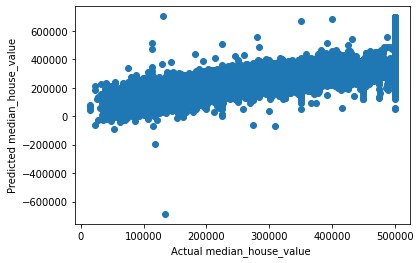

In [126]:
plt.scatter(housing_label,housing_pred)
plt.xlabel('Actual median_house_value ')
plt.ylabel('Predicted median_house_value')

In [127]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())


In [128]:
from sklearn.model_selection import cross_val_score
scores=cross_val_score(lin_reg,housing_prepared,housing_label,scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-scores)
display_scores(lin_rmse_scores)

Scores: [65000.67382615 70960.56056304 67122.63935124 66089.63153865
 68402.54686442 65266.34735288 65218.78174481 68525.46981754
 72739.87555996 68957.34111906]
Mean: 67828.38677377408
Standard deviation: 2468.0913950652257


### Decision Tree

In [129]:

from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
d_tree=DecisionTreeRegressor(random_state = 42)
d_tree.fit(housing_prepared,housing_label)

DecisionTreeRegressor(random_state=42)

In [130]:
housing_pred = d_tree.predict(housing_prepared)
rmse = float(format(np.sqrt(mean_squared_error(housing_label, housing_pred)), '.3f'))
print("\nRMSE: ", rmse)


RMSE:  0.0


In [131]:
# Cross Validations
from sklearn.model_selection import cross_val_score
scores=cross_val_score(d_tree,housing_prepared,housing_label,scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [132]:
display_scores(tree_rmse_scores)

Scores: [65312.86044031 70581.69865676 67849.75809965 71460.33789358
 74035.29744574 65562.42978503 67964.10942543 69102.89388457
 66876.66473025 69735.84760006]
Mean: 68848.18979613911
Standard deviation: 2579.6785558576307


### Random Forest 

In [133]:
from sklearn.ensemble import RandomForestRegressor
random_forest=RandomForestRegressor(n_estimators=10,random_state=0)
random_forest.fit(housing_prepared,housing_label)

RandomForestRegressor(n_estimators=10, random_state=0)

In [134]:
housing_pred = random_forest.predict(housing_prepared)
rmse = float(format(np.sqrt(mean_squared_error(housing_label, housing_pred)), '.3f'))
print("\nRMSE: ", rmse)


RMSE:  22221.832


In [135]:
# Cross Validations
from sklearn.model_selection import cross_val_score
scores=cross_val_score(random_forest,housing_prepared,housing_label,scoring="neg_mean_squared_error", cv=10)
random_rmse_scores = np.sqrt(-scores)

In [136]:
display_scores(random_rmse_scores)

Scores: [49531.9117368  54238.90132009 51791.40143668 54470.93639188
 54532.19137944 48525.53537106 49618.53982537 53110.48500172
 51390.98600347 52332.71045919]
Mean: 51954.359892571796
Standard deviation: 2076.111029189383


### Grid Search

In [139]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_label)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [140]:
print(grid_search.best_params_)
print(grid_search.best_estimator_)


{'max_features': 8, 'n_estimators': 30}
RandomForestRegressor(max_features=8, n_estimators=30, random_state=42)


In [141]:
random_forest=RandomForestRegressor(n_estimators=30,max_features=8,random_state=42)
random_forest.fit(housing_prepared,housing_label)
from sklearn.model_selection import cross_val_score
scores=cross_val_score(random_forest,housing_prepared,housing_label,scoring="neg_mean_squared_error", cv=10)
random_rmse_scores = np.sqrt(-scores)
display_scores(random_rmse_scores)

Scores: [47434.65944602 50515.51213132 48237.53031018 50531.06763401
 52039.68041997 46904.59875957 47460.06174483 50140.20719581
 48817.09594064 50114.21545463]
Mean: 49219.46290369915
Standard deviation: 1605.2330735523904


In [144]:
# Evaluate on test dataset
X_test = test_set.drop(['median_house_value'],axis=1)
y_test=test_set['median_house_value'].copy()
X_test_prepared=full_pipeline.fit_transform(X_test)


In [145]:
final_model=grid_search.best_estimator_
final_pred=final_model.predict(X_test_prepared)

rmse = float(format(np.sqrt(mean_squared_error(y_test, final_pred)), '.3f'))
print("\nRMSE: ", rmse)


RMSE:  68502.718


### SVM

In [147]:
from sklearn.svm import SVR

In [148]:
param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
  ]
svm_reg = SVR()

grid_search = GridSearchCV(svm_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',verbose=2, n_jobs=4)
grid_search.fit(housing_prepared, housing_label)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  6.7min
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed: 11.0min finished


GridSearchCV(cv=5, estimator=SVR(), n_jobs=4,
             param_grid=[{'C': [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0,
                                10000.0, 30000.0],
                          'kernel': ['linear']},
                         {'C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0],
                          'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
                          'kernel': ['rbf']}],
             scoring='neg_mean_squared_error', verbose=2)

In [154]:
nextgative_mse=grid_search.best_score_
rmse=np.sqrt(-nextgative_mse)
print('Grid Search RMSE')
print(rmse)

Grid Search RMSE
69000.11695711924


In [150]:
# svm with randomsearch
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal
param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {
    'kernel': ['linear','rbf'],
     'C': reciprocal(20, 200000),
     'gamma': expon(scale=1.0),
    }
  ]
random_search = RandomizedSearchCV(svm_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',verbose=2, n_jobs=4,random_state=42)
random_search.fit(housing_prepared, housing_label)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:  2.4min finished


RandomizedSearchCV(cv=5, estimator=SVR(), n_jobs=4,
                   param_distributions=[{'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb729ad9a90>,
                                         'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb729ad0a10>,
                                         'kernel': ['linear', 'rbf']}],
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [155]:
nextgative_mse=random_search.best_score_
rmse=np.sqrt(-nextgative_mse)
print('Random Search RMSE')
print(rmse)

Random Search RMSE
54188.701639496445


In [156]:
random_search.best_params_


{'C': 157055.10989448498, 'gamma': 0.26497040005002437, 'kernel': 'rbf'}

In [158]:
feature_importances=random_search.best_estimator_.feature_importances_
feature_importances

AttributeError: 'SVR' object has no attribute 'feature_importances_'